# Séries Temporais - Multivariada - Água Bruta/Chuva/Temperatura Máx/Temperatura Mín/Umidade Relativa

In [0]:
# !pip install scipy==1.2  --user
# !pip install --upgrade Cython
# !pip install --upgrade git+https://github.com/statsmodels/statsmodels

##Montagem do Drive e Importação de Bibliotecas

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.rcParams['figure.figsize'] = [20, 10]

%matplotlib inline

sns.set(style="darkgrid")
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

#from matplotlib.pyplot import figure
#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')


from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Tratamento dos Dados

###Dados de Água Bruta

In [0]:
#Drive João
# df_vazao_agua_hora = pd.read_excel('gdrive/My Drive/projetos/lm/Dados_apurados.xlsx', 'vazoes_agua_hora', parse_dates=True, na_values='Null', keep_default_na=False)


#Drive Bruno
df_vazao_agua_hora = pd.read_excel('gdrive/My Drive/Material BSI/LM/Projeto_LM/Dados_apurados.xlsx', 'vazoes_agua_hora')

#Padronização das datas
df_vazao_agua_hora['Data'] = pd.to_datetime(df_vazao_agua_hora['Data'])
df_vazao_agua_hora['Data_dia'] = df_vazao_agua_hora['Data'].map(lambda x: x.strftime('%Y-%m-%d'))

#Tratamento Geral
df_vazao_agua_hora['agua_bruta_m3/h'] = df_vazao_agua_hora['agua_bruta_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()

#Agrupamento dos dados de horários para diários
df_volume_agua_dia = df_vazao_agua_hora.groupby('Data_dia')

#Totalização das vazões horárias em VOLUME DIÁRIO
df_volume_agua_dia = df_volume_agua_dia.aggregate(np.sum)
df_volume_agua_dia = df_volume_agua_dia.rename(columns={'agua_bruta_m3/h': 'agua_bruta_m3'})


print(df_volume_agua_dia.dtypes)
df_volume_agua_dia.head()

agua_bruta_m3    float64
dtype: object


,agua_bruta_m3
Data_dia,
2015-01-01,9449.860189
2015-01-02,14190.898285
2015-01-03,14592.745667
2015-01-04,10225.120845
2015-01-05,8463.903225


###Dados Metereológicos

In [0]:
#Drive João
# df_tempo = pd.read_excel('gdrive/My Drive/projetos/lm/Dados_apurados.xlsx', 'dados_tempo_diarios')

#Drive Bruno
df_tempo = pd.read_excel('gdrive/My Drive/Material BSI/LM/Projeto_LM/Dados_apurados.xlsx', 'dados_tempo_diarios')

#Padronização das datas
df_tempo = df_tempo.rename(columns={'Dia': 'Data_dia'})
df_tempo['Data_dia'] = df_tempo['Data_dia'].map(lambda x: x.strftime('%Y-%m-%d'))

print(df_tempo.dtypes)
df_tempo.head()
#print(df)

Data_dia                   object
Chuva                     float64
TempMaxima                float64
TempMinima                float64
Umidade Relativa Media    float64
dtype: object


,Data_dia,Chuva,TempMaxima,TempMinima,Umidade Relativa Media
0,2015-01-01,0.0,28.4,23.0,88.75
1,2015-01-02,37.0,30.2,23.0,75.25
2,2015-01-03,0.0,30.8,20.8,72.25
3,2015-01-04,0.0,31.4,20.4,67.50
4,2015-01-05,0.0,32.0,22.2,69.50


####Preenchendo dados ausentes

In [0]:
df_tempo.isnull().sum()

Data_dia                   0
Chuva                      0
TempMaxima                 2
TempMinima                 3
Umidade Relativa Media    10
dtype: int64

In [0]:
#Acrescentando valores médios nos dados ausentes
TempMaxMedia = df_tempo['TempMaxima'].mean()
TempMaxMedia = round(TempMaxMedia, 1)
df_tempo.update(df_tempo['TempMaxima'].fillna(TempMaxMedia))

TempMinMedia = df_tempo['TempMinima'].mean()
TempMinMedia = round(TempMinMedia, 1)
df_tempo.update(df_tempo['TempMinima'].fillna(TempMinMedia))

UmidMedia = df_tempo['Umidade Relativa Media'].mean()
UmidMedia = round(UmidMedia, 2)
df_tempo.update(df_tempo['Umidade Relativa Media'].fillna(UmidMedia))

df_tempo.isnull().sum()

Data_dia                  0
Chuva                     0
TempMaxima                0
TempMinima                0
Umidade Relativa Media    0
dtype: int64

###Junção dos Dados

In [0]:
df_agua_tempo = pd.merge(df_volume_agua_dia, df_tempo, on='Data_dia')

#Reconvertendo Data_dia para DateTime
df_agua_tempo['Data_dia'] = pd.to_datetime(df_agua_tempo['Data_dia'])

print(df_agua_tempo.dtypes)
df_agua_tempo.head()

Data_dia                  datetime64[ns]
agua_bruta_m3                    float64
Chuva                            float64
TempMaxima                       float64
TempMinima                       float64
Umidade Relativa Media           float64
dtype: object


,Data_dia,agua_bruta_m3,Chuva,TempMaxima,TempMinima,Umidade Relativa Media
0,2015-01-01,9449.860189,0.0,28.4,23.0,88.75
1,2015-01-02,14190.898285,37.0,30.2,23.0,75.25
2,2015-01-03,14592.745667,0.0,30.8,20.8,72.25
3,2015-01-04,10225.120845,0.0,31.4,20.4,67.50
4,2015-01-05,8463.903225,0.0,32.0,22.2,69.50


###Plotando Dados

<Figure size 576x360 with 0 Axes>

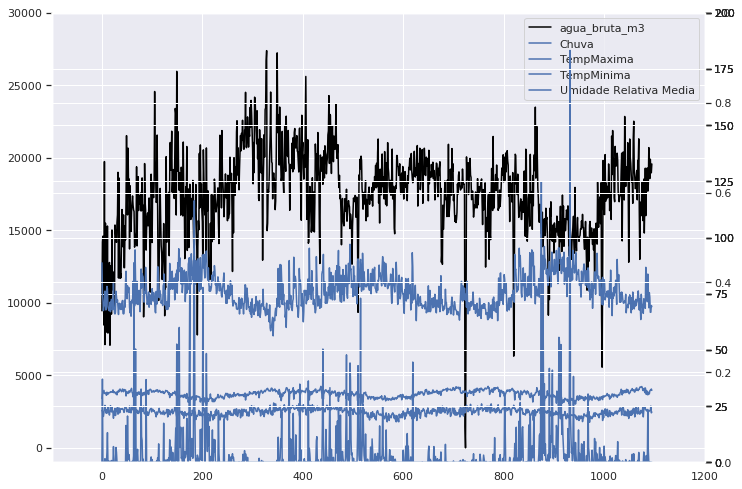

In [0]:
fig = plt.figure(figsize=(8, 5))

fig, host = plt.subplots()

ax1 = host.twinx()
ax2 = host.twinx()
ax3 = host.twinx()
ax4 = host.twinx()
ax5 = host.twinx()


p1, = host.plot(df_agua_tempo['agua_bruta_m3'], color='black')
p2, = ax1.plot(df_agua_tempo['Chuva'])
p3, = ax2.plot(df_agua_tempo['TempMaxima'])
p4, = ax3.plot(df_agua_tempo['TempMinima'])
p5, = ax4.plot(df_agua_tempo['Umidade Relativa Media'])

host.set_xlim(-100, 1200)
host.set_ylim(-1000, 30000)
ax1.set_ylim(0, 200)
ax2.set_ylim(0, 200)
ax3.set_ylim(0, 200)
ax4.set_ylim(0, 200)


lines = [p1, p2, p3, p4, p5]

host.legend(lines, [l.get_label() for l in lines])

plt.show()


# lns1 = ax1.plot(df_agua_tempo['agua_bruta_m3'], color='black')
# lns2 = ax2.plot(df_agua_tempo[['Chuva','TempMaxima', 'TempMinima', 'Umidade Relativa Media']])

# Solution for having two legends
# leg = lns1 + lns2
# labs = [l.get_label() for l in leg]
# ax1.legend(leg, labs, loc=0)
# plt.title('Variáveis Obtidas', fontsize=20)

# # df_agua_tempo[['agua_bruta_m3','Chuva','TempMaxima', 'TempMinima', 'Umidade Relativa Media']].plot()
# # fig.tight_layout()
# plt.show()
# print(labs)
# print(l.get_label() for l in lns2)

##Teste Dick Fuller
**Return**

**adf**:float (Test statistic)

**pvalue**:float
(MacKinnon’s approximate p-value based on MacKinnon (1994, 2010))

**usedlag**:int
(Number of lags used)

**nobs**:int
(Number of observations used for the ADF regression and calculation of the critical values)

**critical values**:dict
(Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010))

**icbest**:float
(The maximized information criterion if autolag is not None.)

**resstore**: ResultStore, optional
(A dummy class with results attached as attributes)

###Teste variáveis sem diferenciação

In [0]:
print('Resultados de Água Bruta')
print(sm.tsa.stattools.adfuller(df_agua_tempo['agua_bruta_m3']),'\n')

print('Resultados de Chuva')
print(sm.tsa.stattools.adfuller(df_agua_tempo['Chuva']),'\n')

print('Resultados de TempMaxima')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMaxima']),'\n')

print('Resultados de TempMinima')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMinima']),'\n')

print('Resultados de UmidMedia')
print(sm.tsa.stattools.adfuller(df_agua_tempo['Umidade Relativa Media']))

Resultados de Água Bruta
(-4.9166335756198665, 3.2365585396321904e-05, 9, 1086, {'1%': -3.4363857496063455, '5%': -2.8642050392821794, '10%': -2.5681889563132314}, 19501.51516556401) 

Resultados de Chuva
(-3.9001759184771396, 0.0020335528245859886, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 8305.257644110083) 

Resultados de TempMaxima
(-1.9492664987088821, 0.3092510221381819, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 2895.8303004756335) 

Resultados de TempMinima
(-2.8381261139888494, 0.05303071636227612, 15, 1080, {'1%': -3.436419361753321, '5%': -2.864219865461312, '10%': -2.5681968527091907}, 3281.8750292536547) 

Resultados de UmidMedia
(-2.384868682790192, 0.14605273296662613, 20, 1075, {'1%': -3.4364476591811033, '5%': -2.864232347211692, '10%': -2.5682035004867494}, 6561.606001761516)


###Aplicando diferenciação (Temperaturas Máxima, Mínima e Umidade Relativa Média)

In [0]:
df_agua_tempo['TempMaxima_diff']=df_agua_tempo['TempMaxima'].diff()
df_agua_tempo['TempMinima_diff']=df_agua_tempo['TempMinima'].diff()
df_agua_tempo['UmidRelatMedia_diff']=df_agua_tempo['Umidade Relativa Media'].diff()

#Acrescentando valores médios nos dados ausentes
TempMaxMediaD = df_agua_tempo['TempMaxima_diff'].mean()
TempMaxMediaD = round(TempMaxMediaD, 1)
df_agua_tempo.update(df_agua_tempo['TempMaxima_diff'].fillna(TempMaxMediaD))

TempMinMediaD = df_agua_tempo['TempMinima_diff'].mean()
TempMinMediaD = round(TempMinMediaD, 1)
df_agua_tempo.update(df_agua_tempo['TempMinima_diff'].fillna(TempMinMediaD))

UmidMediaD = df_agua_tempo['UmidRelatMedia_diff'].mean()
UmidMediaD = round(UmidMediaD, 2)
df_agua_tempo.update(df_agua_tempo['UmidRelatMedia_diff'].fillna(UmidMediaD))

df_agua_tempo.isna().sum()

Data_dia                  0
agua_bruta_m3             0
Chuva                     0
TempMaxima                0
TempMinima                0
Umidade Relativa Media    0
TempMaxima_diff           0
TempMinima_diff           0
UmidRelatMedia_diff       0
dtype: int64

###Teste variáveis com diferenciação

In [0]:
print('Resultados de TempMaximaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMaxima_diff']),'\n')

print('Resultados de TempMinimaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['TempMinima_diff']),'\n')

print('Resultados de UmidMediaDiff')
print(sm.tsa.stattools.adfuller(df_agua_tempo['UmidRelatMedia_diff']))

Resultados de TempMaximaDiff
(-11.57576557618353, 3.0254531191685056e-21, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 2897.7713696721103) 

Resultados de TempMinimaDiff
(-11.478681428089734, 5.056843530340475e-21, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 3287.5364733671977) 

Resultados de UmidMediaDiff
(-12.333296680035408, 6.355148817603613e-23, 19, 1076, {'1%': -3.436441978605957, '5%': -2.864229841568573, '10%': -2.5682021659802934}, 6565.474849414404)


##OLS Regression

###Sem diferenciação das variáveis não-estacionárias

In [0]:
df_agua_tempo['const']=1
model1=sm.OLS(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['Chuva','TempMaxima','TempMinima','Umidade Relativa Media','const']])
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:          agua_bruta_m3   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     14.60
Date:                Sun, 30 Jun 2019   Prob (F-statistic):           1.28e-11
Time:                        02:29:34   Log-Likelihood:                -10284.
No. Observations:                1096   AIC:                         2.058e+04
Df Residuals:                    1091   BIC:                         2.060e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Chuva                    -10

###Aplicando diferenciação das variáveis não-estacionárias

In [0]:
model2=sm.OLS(endog=df_agua_tempo['agua_bruta_m3'].dropna(),exog=df_agua_tempo[['Chuva','TempMaxima_diff','TempMinima_diff','UmidRelatMedia_diff','const']])
results2=model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:          agua_bruta_m3   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.387
Date:                Sun, 30 Jun 2019   Prob (F-statistic):            0.00917
Time:                        02:29:37   Log-Likelihood:                -10305.
No. Observations:                1096   AIC:                         2.062e+04
Df Residuals:                    1091   BIC:                         2.065e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Chuva                 -25.9439    

##Teste Causalidade de Granger

###Influência da chuva no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','Chuva']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6861  , p=0.1944  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=1.6907  , p=0.1935  , df=1
likelihood ratio test: chi2=1.6894  , p=0.1937  , df=1
parameter F test:         F=1.6861  , p=0.1944  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (1.6860858281853544, 0.19439189494165346, 1092.0, 1), 'ssr_chi2test': (1.6907179321089407, 0.19350635695967944, 1), 'lrtest': (1.6894140106087434, 0.19367823347719876, 1), 'params_ftest': (1.6860858281846751, 0.19439189494170958, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a78268d0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a7826908>, array([[0., 1., 0.]])])}


###Influência da temperatura máxima no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','TempMaxima_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1388  , p=0.7095  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1392  , p=0.7091  , df=1
likelihood ratio test: chi2=0.1392  , p=0.7091  , df=1
parameter F test:         F=0.1388  , p=0.7095  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.13884307432410897, 0.7095061790869481, 1092.0, 1), 'ssr_chi2test': (0.1392245113414829, 0.709053173159329, 1), 'lrtest': (0.13921566119825002, 0.7090619994486335, 1), 'params_ftest': (0.13884307432406778, 0.7095061790869481, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1fd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1ef0>, array([[0., 1., 0.]])])}


###Influência da temperatura mínima no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','TempMinima_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1562  , p=0.6928  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1566  , p=0.6923  , df=1
likelihood ratio test: chi2=0.1566  , p=0.6923  , df=1
parameter F test:         F=0.1562  , p=0.6928  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.15617740557055912, 0.6927777361345897, 1092.0, 1), 'ssr_chi2test': (0.15660646437707165, 0.69230027707297, 1), 'lrtest': (0.15659526654781075, 0.6923107156519713, 1), 'params_ftest': (0.15617740557074458, 0.6927777361343633, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1b70>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1ef0>, array([[0., 1., 0.]])])}


###Influência da umidade relativa média no consumo da água bruta

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df_agua_tempo[['agua_bruta_m3','UmidRelatMedia_diff']].dropna(), 1, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1882  , p=0.6645  , df_denom=1092, df_num=1
ssr based chi2 test:   chi2=0.1887  , p=0.6640  , df=1
likelihood ratio test: chi2=0.1887  , p=0.6640  , df=1
parameter F test:         F=0.1882  , p=0.6645  , df_denom=1092, df_num=1
{1: ({'ssr_ftest': (0.18820663592658168, 0.6644991208844334, 1092.0, 1), 'ssr_chi2test': (0.1887236871241822, 0.6639810111777459, 1), 'lrtest': (0.18870742569197319, 0.663994600129151, 1), 'params_ftest': (0.1882066359265648, 0.6644991208846363, 1092.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1ef0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f61a73f1e10>, array([[0., 1., 0.]])])}


###Aplicação ARIMA 

####**Água Bruta x Chuva**

In [0]:
df_agua_tempo['lagCHU']=df_agua_tempo['Chuva'].shift()

df_agua_tempo.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagCHU']],order=[1,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1090
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10021.786
Method:                       css-mle   S.D. of innovations           2381.073
Date:                Sun, 30 Jun 2019   AIC                          20051.571
Time:                        02:39:02   BIC                          20071.547
Sample:                             1   HQIC                         20059.132
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -11.3424     58.129     -0.195      0.845    -125.274     102.589
lagCHU                    3.3436      5.083      0.658      0.511      -6.618      13.305
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results3.params)
print('Standard errors: ', results3.bse)
print('Predicted values: ', results3.predict())

Parameters:  const                   -11.342438
lagCHU                    3.343618
ar.L1.D.agua_bruta_m3    -0.331774
dtype: float64
Standard errors:  const                    58.129344
lagCHU                    5.082621
ar.L1.D.agua_bruta_m3     0.028930
dtype: float64
Predicted values:  6        -11.342438
7       4177.710563
8      -2791.285737
9        556.624995
10         1.846960
11      1909.472009
12     -2395.654923
13      2448.541317
14     -1523.566888
15       -23.626646
16      -110.357428
17      1877.739785
18     -1733.406907
19      -120.650604
20      1101.672379
21     -1939.715775
22      1353.528293
23      -425.636058
24       410.937691
25      -377.812734
26       760.663005
27     -1894.834585
28       152.378712
29       165.783313
30        77.449306
31      -465.610986
32      -185.324046
33      -990.660137
34      2403.255630
35     -2304.784249
           ...     
1066    -191.038946
1067     656.847158
1068    -913.811717
1069      34.785432
1070    -5

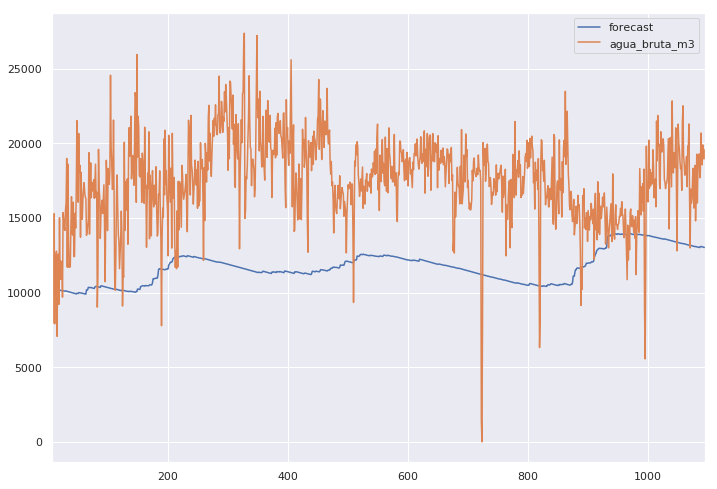

In [0]:
fig = results3.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

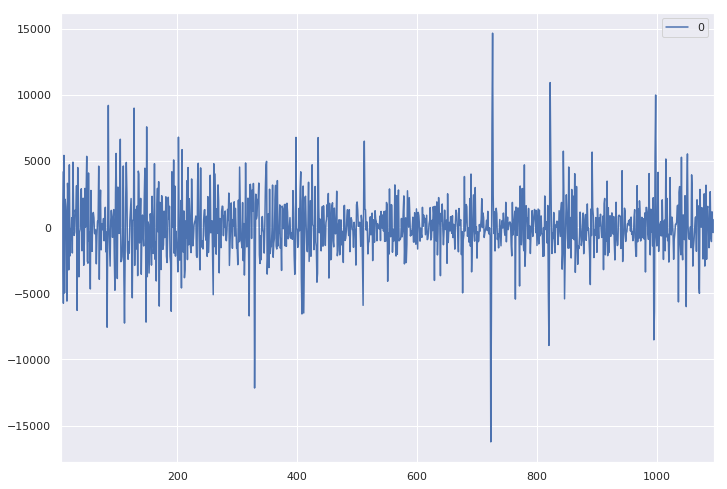

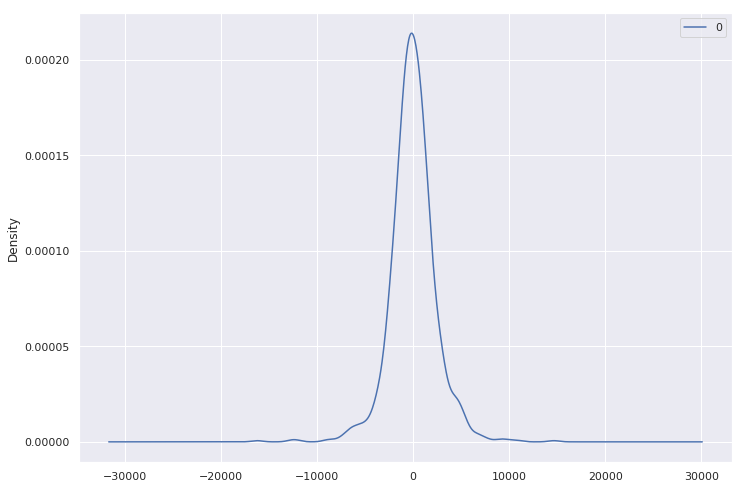

                  0
count   1090.000000
mean      -3.760601
std     2385.534677
min   -16233.771072
25%    -1166.389503
50%      -62.509195
75%     1207.404343
max    14650.664985


In [0]:
# plot residual errors
residuals = pd.DataFrame(results3.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

####**Água Bruta x Temperatura Máxima**

In [0]:
df_agua_tempo['lagTempMax']=df_agua_tempo['TempMaxima_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model4=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagTempMax']],order=[1,1,0])
results4=model4.fit()
print(results4.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1089
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10004.473
Method:                       css-mle   S.D. of innovations           2363.398
Date:                Sun, 30 Jun 2019   AIC                          20016.945
Time:                        02:39:19   BIC                          20036.917
Sample:                             1   HQIC                         20024.505
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.3287     54.285      0.172      0.864     -97.068     115.725
lagTempMax              -36.2212     72.678     -0.498      0.618    -178.667     106.225
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results4.params)
print('Standard errors: ', results4.bse)
print('Predicted values: ', results4.predict())

Parameters:  const                     9.328670
lagTempMax              -36.221170
ar.L1.D.agua_bruta_m3    -0.319598
dtype: float64
Standard errors:  const                    54.285027
lagTempMax               72.678032
ar.L1.D.agua_bruta_m3     0.028875
dtype: float64
Predicted values:  7          2.084435
8      -2669.632202
9        570.190310
10        60.235378
11      1810.635564
12     -2308.077200
13      2364.901771
14     -1439.335004
15       -13.626151
16       -85.875329
17      1835.688562
18     -1658.706911
19       -94.419404
20      1092.770116
21     -1843.829236
22      1333.179978
23      -418.217595
24       432.060519
25      -337.918895
26       750.048703
27     -1786.260183
28       192.766702
29       177.177133
30        53.581690
31      -392.803558
32      -188.693317
33      -936.404374
34      2315.256433
35     -2180.866308
36      1499.576205
           ...     
1066    -173.522537
1067     698.288012
1068    -846.878802
1069      65.601828
1070    -5

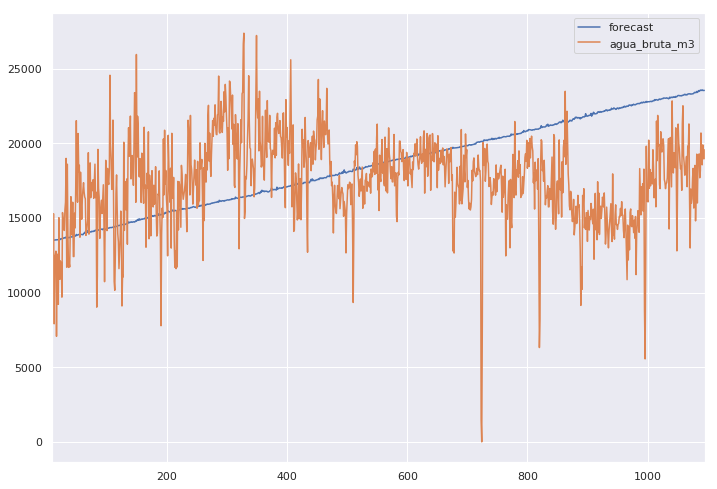

In [0]:
fig = results4.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

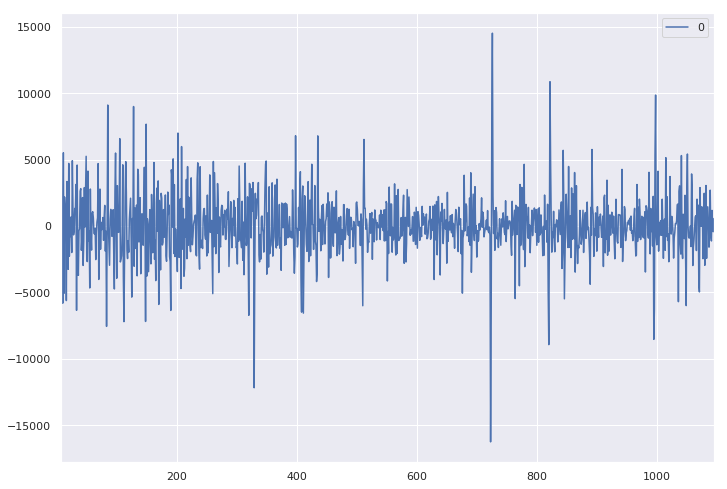

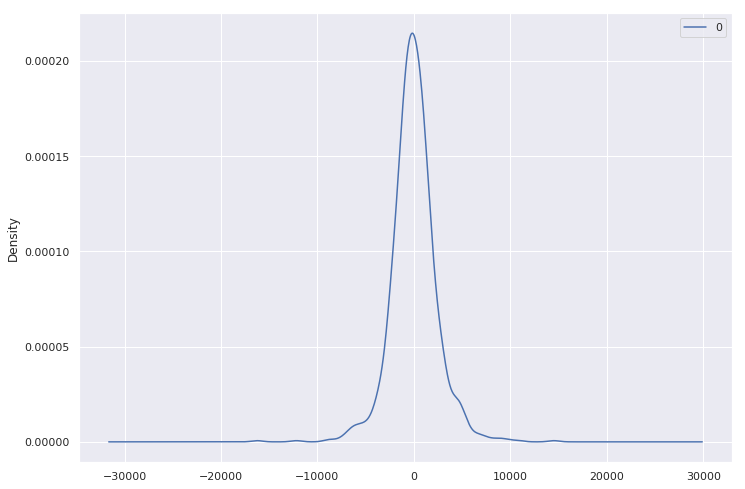

                  0
count   1089.000000
mean       2.688106
std     2365.872861
min   -16259.146908
25%    -1165.601519
50%      -70.245138
75%     1205.888572
max    14518.189739


In [0]:
# plot residual errors
residuals = pd.DataFrame(results4.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

####**Água Bruta x Temperatura Mínima**

In [0]:
df_agua_tempo['lagTempMin']=df_agua_tempo['TempMinima_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model5=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagTempMin']],order=[1,1,0])
results5=model5.fit()
print(results5.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1088
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9990.286
Method:                       css-mle   S.D. of innovations           2352.564
Date:                Sun, 30 Jun 2019   AIC                          19988.572
Time:                        02:39:38   BIC                          20008.541
Sample:                             1   HQIC                         19996.131
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.9587     54.151      0.073      0.942    -102.175     110.092
lagTempMin               27.9754     55.378      0.505      0.614     -80.564     136.514
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results5.params)
print('Standard errors: ', results5.bse)
print('Predicted values: ', results5.predict())

Parameters:  const                     3.958727
lagTempMin               27.975380
ar.L1.D.agua_bruta_m3    -0.317407
dtype: float64
Standard errors:  const                    54.150718
lagTempMin               55.378067
ar.L1.D.agua_bruta_m3     0.028742
dtype: float64
Predicted values:  8        -26.814191
9        478.315388
10        -4.545517
11      1875.361558
12     -2344.100140
13      2402.877867
14     -1455.778801
15       -45.262926
16      -123.403597
17      1857.569699
18     -1556.832831
19       -97.253121
20      1008.019213
21     -1798.709856
22      1298.771062
23      -431.763749
24       312.621107
25      -281.004192
26       731.044321
27     -1728.991014
28       100.788482
29       173.504675
30        92.485240
31      -390.149646
32      -134.222841
33     -1008.468604
34      2342.569651
35     -2141.353482
36      1444.304801
37       695.222184
           ...     
1066    -166.603731
1067     634.702955
1068    -877.336151
1069     125.988035
1070    -5

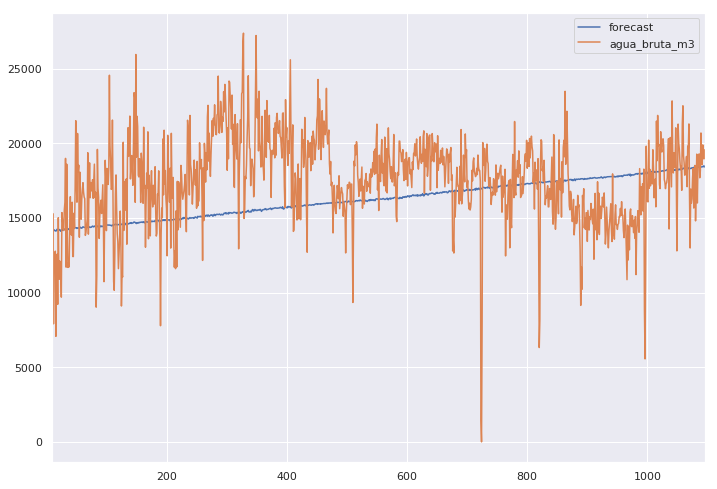

In [0]:
fig = results5.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

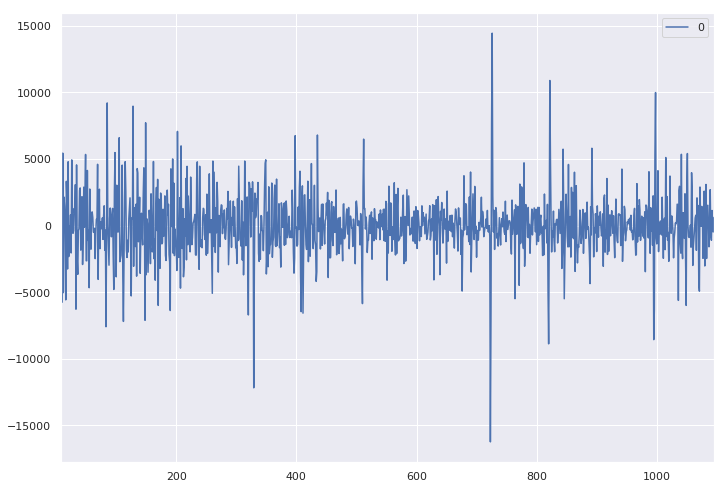

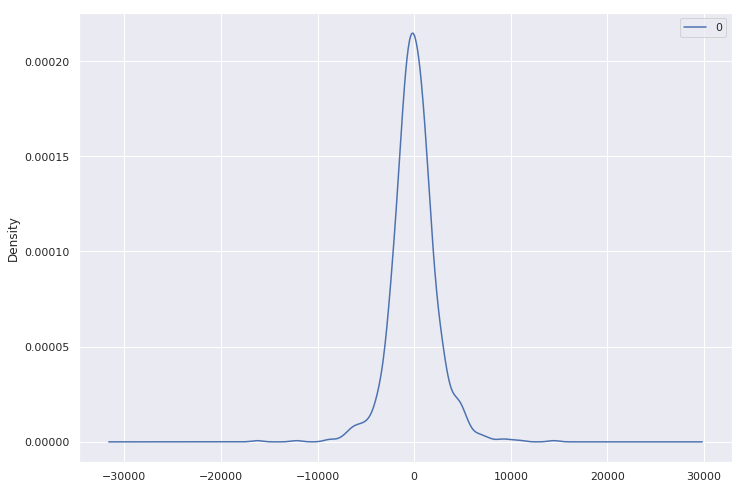

                  0
count   1088.000000
mean      -0.361391
std     2353.701789
min   -16248.098679
25%    -1186.589409
50%      -64.865805
75%     1217.465760
max    14455.256771


In [0]:
# plot residual errors
residuals = pd.DataFrame(results5.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

####**Água Bruta x Umidade Relativa Média**


In [0]:
df_agua_tempo['lagUmid']=df_agua_tempo['UmidRelatMedia_diff'].shift()

df_agua_tempo.dropna(inplace=True)
model6=sm.tsa.ARIMA(endog=df_agua_tempo['agua_bruta_m3'],exog=df_agua_tempo[['lagUmid']],order=[1,1,0])
results6=model6.fit()
print(results6.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.agua_bruta_m3   No. Observations:                 1087
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9981.049
Method:                       css-mle   S.D. of innovations           2352.444
Date:                Sun, 30 Jun 2019   AIC                          19970.098
Time:                        02:39:57   BIC                          19990.062
Sample:                             1   HQIC                         19977.655
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.3163     54.147      0.098      0.922    -100.810     111.443
lagUmid                 -11.4857     12.638     -0.909      0.364     -36.256      13.284
ar.L1.D.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results6.params)
print('Standard errors: ', results6.bse)
print('Predicted values: ', results6.predict())

Parameters:  const                     5.316328
lagUmid                 -11.485735
ar.L1.D.agua_bruta_m3    -0.318028
dtype: float64
Standard errors:  const                    54.147243
lagUmid                  12.637922
ar.L1.D.agua_bruta_m3     0.028754
dtype: float64
Predicted values:  9         34.030666
10       -57.475976
11      1777.847096
12     -2320.455146
13      2450.080816
14     -1398.246710
15         9.183073
16       -93.682424
17      1786.188275
18     -1602.613319
19      -127.880352
20      1045.068384
21     -1834.663822
22      1367.617337
23      -406.360133
24       275.761244
25      -264.175189
26       825.403167
27     -1777.225395
28       160.764119
29        48.771910
30        70.550958
31      -394.702813
32      -159.638456
33      -891.580409
34      2372.411114
35     -2231.403068
36      1481.458040
37       737.260378
38       -82.125370
           ...     
1066    -165.948942
1067     637.938733
1068    -891.352738
1069      23.835067
1070    -4

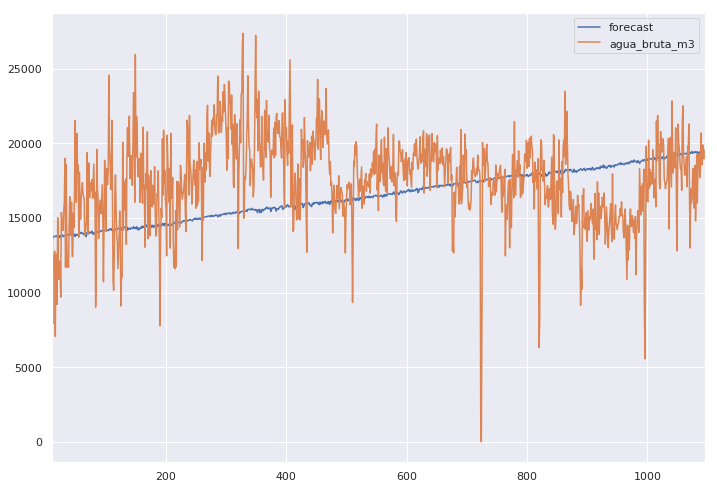

In [0]:
fig = results6.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

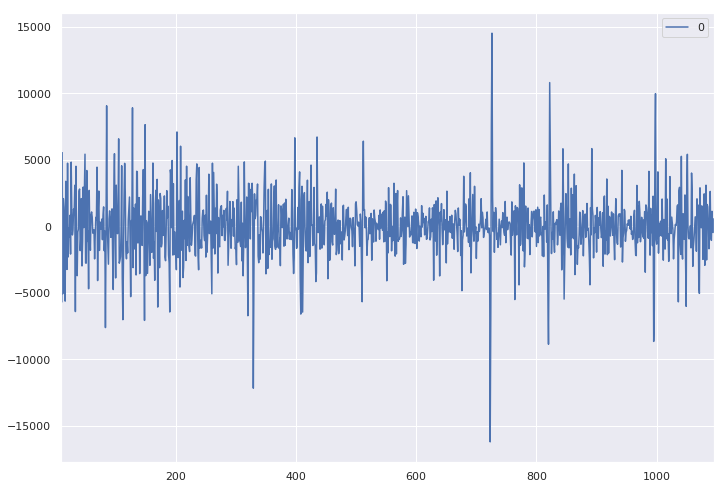

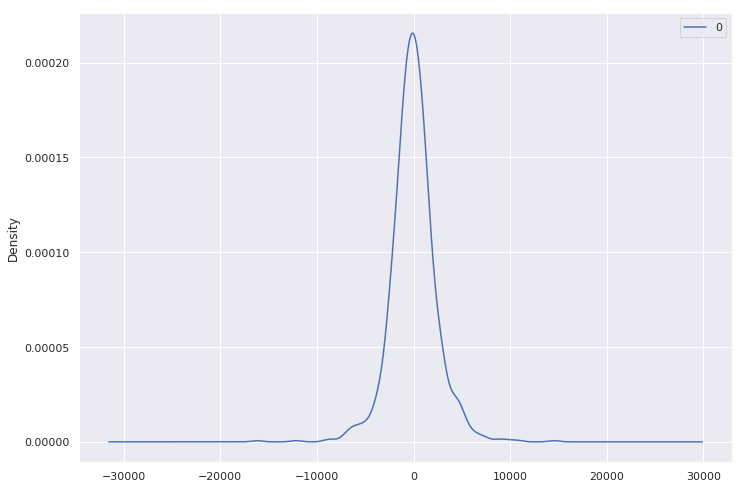

                  0
count   1087.000000
mean      -0.171049
std     2353.526759
min   -16196.135574
25%    -1197.719392
50%      -66.749289
75%     1179.563225
max    14535.653144


In [0]:
# plot residual errors
residuals = pd.DataFrame(results6.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Exemplo salesdata2 

In [0]:
#!pip install scipy==1.2  --user
#!pip install --upgrade Cython
#!pip install --upgrade git+https://github.com/statsmodels/statsmodels



In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.rcParams['figure.figsize'] = [20, 10]

%matplotlib inline

sns.set(style="darkgrid")
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

#from matplotlib.pyplot import figure
#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')





In [0]:
df = pd.read_csv('gdrive/My Drive/projetos/lm/salesdata2.csv')
print(df)

    Month    Marketing         Sales
0       1   107.284347    123.819229
1       2   214.523447    267.318463
2       3   327.159934    482.107206
3       4   437.384597    762.756909
4       5   518.389038    997.734857
5       6   657.617312    968.322453
6       7   727.253623   1228.443301
7       8   847.472727   1396.419992
8       9   972.358451   1440.872584
9      10  1053.528271   1971.237443
10     11  1124.267276   1319.674162
11     12  1315.481113   2446.432673
12     13  1314.640290   2210.117384
13     14  1487.804772   1830.658645
14     15  1512.189986   3116.543639
15     16  1615.715607   2477.861264
16     17  1807.511713   3493.673158
17     18  1821.351928   2882.649744
18     19  2032.154162   3967.267046
19     20  2011.958560   2770.931302
20     21  2232.497208   4403.717617
21     22  2262.475519   3816.263437
22     23  2370.528160   3573.094404
23     24  2594.093338   3987.431523
24     25  2697.492509   3468.400610
25     26  2704.133355   5611.814312
2

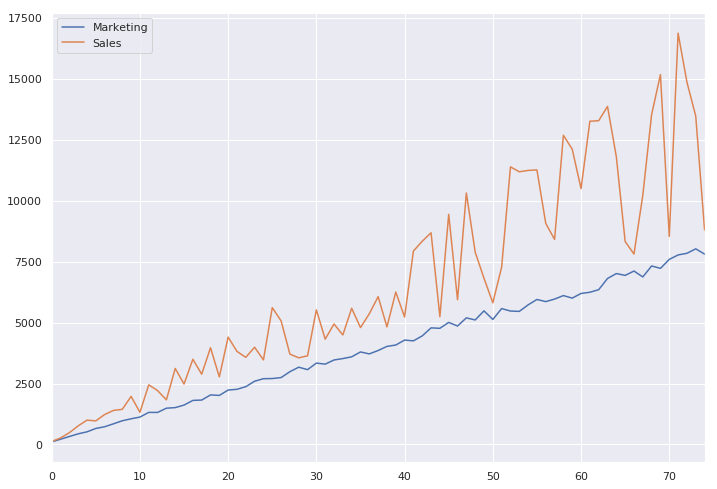

In [0]:
df[['Marketing','Sales']].plot()
plt.show()

In [0]:
print(sm.tsa.stattools.adfuller(df['Marketing']))
print(sm.tsa.stattools.adfuller(df['Sales']))

(0.11973556900175938, 0.9673829869360326, 1, 73, {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}, 788.4679673490132)
(-0.3515085974689588, 0.9178857330152571, 11, 63, {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}, 1117.9090016166876)


In [0]:
df['const']=1
print("Aqui")
model1=sm.OLS(endog=df['Sales'],exog=df[['Marketing','const']])
results1=model1.fit()
print(results1.summary())

Aqui
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     403.9
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           1.79e-31
Time:                        19:58:43   Log-Likelihood:                -661.83
No. Observations:                  75   AIC:                             1328.
Df Residuals:                      73   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Marketing      1.7029      0.085     20.096    

In [0]:
df['diffS']=df['Sales'].diff()
df['diffM']=df['Marketing'].diff()
#print(df)
model2=sm.OLS(endog=df['diffS'].dropna(),exog=df[['diffM','const']].dropna())
results2=model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  diffS   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.708
Date:                Wed, 19 Jun 2019   Prob (F-statistic):              0.104
Time:                        19:58:43   Log-Likelihood:                -671.02
No. Observations:                  74   AIC:                             1346.
Df Residuals:                      72   BIC:                             1351.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffM          2.6104      1.586      1.646      0.1

In [0]:
print(sm.tsa.stattools.grangercausalitytests(df[['Sales','Marketing']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.4561 , p=0.0000  , df_denom=71, df_num=1
ssr based chi2 test:   chi2=34.8698 , p=0.0000  , df=1
likelihood ratio test: chi2=28.5705 , p=0.0000  , df=1
parameter F test:         F=33.4561 , p=0.0000  , df_denom=71, df_num=1
{1: ({'ssr_ftest': (33.456140995943535, 1.810036714936035e-07, 71.0, 1), 'ssr_chi2test': (34.869780756335516, 3.525098908631768e-09, 1), 'lrtest': (28.570467812774496, 9.034970552654862e-08, 1), 'params_ftest': (33.45614099594401, 1.8100367149357443e-07, 71.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f47b4da0fd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f47b4da0d68>, array([[0., 1., 0.]])])}


In [0]:
print(sm.tsa.stattools.grangercausalitytests(df[['Marketing','Sales']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3057  , p=0.5821  , df_denom=71, df_num=1
ssr based chi2 test:   chi2=0.3186  , p=0.5724  , df=1
likelihood ratio test: chi2=0.3179  , p=0.5729  , df=1
parameter F test:         F=0.3057  , p=0.5821  , df_denom=71, df_num=1
{1: ({'ssr_ftest': (0.3056924545283709, 0.5820722496888391, 71.0, 1), 'ssr_chi2test': (0.31860903711407673, 0.5724447641509418, 1), 'lrtest': (0.3179251095340305, 0.5728572543074806, 1), 'params_ftest': (0.30569245452808014, 0.5820722496890105, 71.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f47b4da0fd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f47b4da0780>, array([[0., 1., 0.]])])}


In [0]:
df['lag']=df['diffM'].shift()
df.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df['Sales'],exog=df[['lag']],order=[1,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -647.768
Method:                       css-mle   S.D. of innovations           1951.172
Date:                Wed, 19 Jun 2019   AIC                           1303.535
Time:                        19:58:43   BIC                           1312.642
Sample:                             1   HQIC                          1307.161
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           454.3043    266.811      1.703      0.093     -68.636     977.245
lag              -2.9454      1.977     -1.490      0.141      -6.821       0.930
ar.L1.D.Sales    -0.4596      0.113     

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
print('Parameters: ', results3.params)
print('Standard errors: ', results3.bse)
print('Predicted values: ', results3.predict())

Parameters:  const            454.304310
lag               -2.945433
ar.L1.D.Sales     -0.459595
dtype: float64
Standard errors:  const            266.811125
lag                1.977433
ar.L1.D.Sales      0.113118
dtype: float64
Predicted values:  3      122.541072
4       56.979037
5      167.300645
6      156.874247
7      149.966816
8      137.534590
9      112.086190
10      11.208492
11     644.318225
12    -513.719487
13     515.338804
14     328.591283
15    -234.124586
16     618.697088
17    -508.827462
18     643.522462
19    -475.023704
20     987.050472
21    -709.562799
22     546.247544
23     416.015779
24    -332.094727
25     294.447305
26    -481.533756
27     786.326975
28     526.211932
29    -138.281459
30     672.789162
31    -858.339313
32     977.201217
         ...     
45    1851.934581
46   -1955.285434
47    2382.707738
48   -2134.142513
49    1578.021510
50     175.164115
51    1655.451860
52    -847.669719
53   -1530.342721
54     935.845506
55    -130.544

In [0]:
# preds, stderr, ci = results3.forecast(1)

# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(x, y, 'o', label="data")
# ax.plot(x, y_true, 'b-', label="True")
# ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
# ax.plot(x, iv_u, 'r--')
# ax.plot(x, iv_l, 'r--')
# ax.legend(loc='best');

In [0]:
#results3.plot_predict()

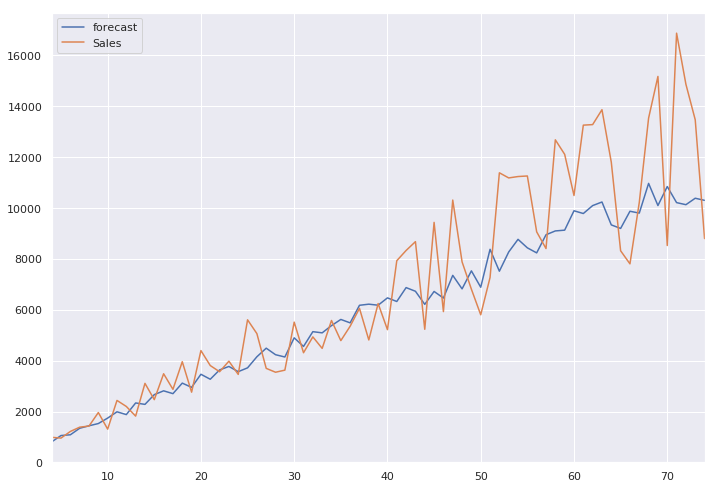

In [0]:
#fig, ax = plt.subplots()
#ax = df.loc['10':].plot(ax=ax)
fig = results3.plot_predict(dynamic=True, plot_insample=True, alpha=0.05)
plt.show()

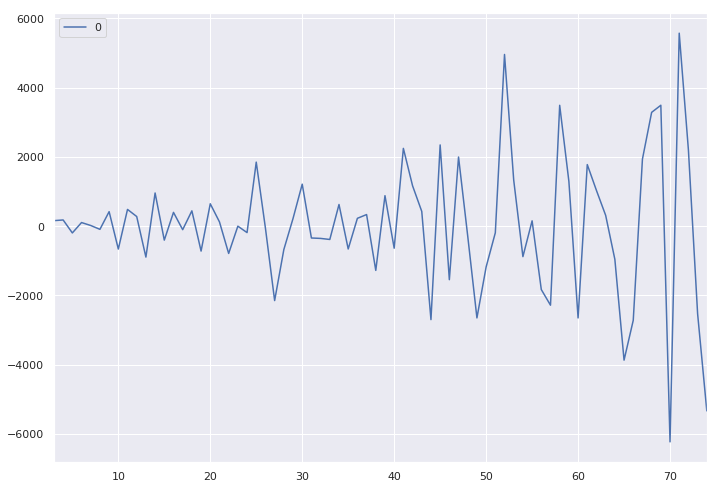

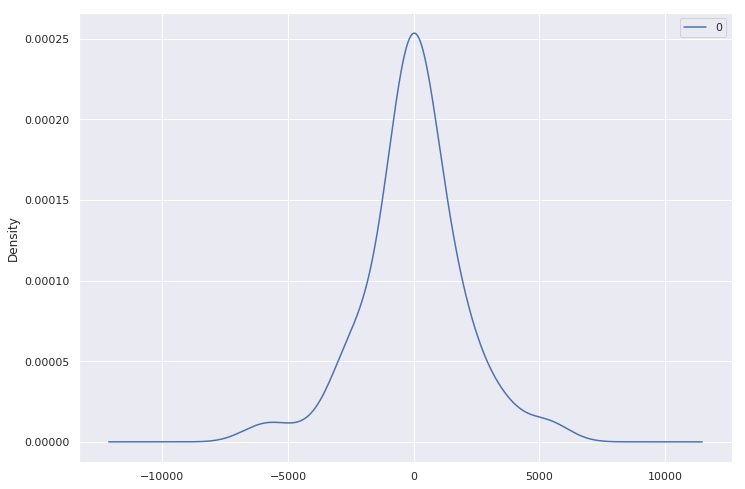

                 0
count    72.000000
mean      1.014393
std    1964.882986
min   -6233.071797
25%    -738.338175
50%      60.628238
75%     899.028450
max    5574.300224


In [0]:
# plot residual errors
residuals = pd.DataFrame(results3.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())